In [1]:
# CÉLULA 1: IMPORTAÇÃO DAS BIBLIOTECAS

import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib # Para salvar nosso modelo

# Mensagem de confirmação
print("Bibliotecas de modelagem importadas com sucesso!")

Bibliotecas de modelagem importadas com sucesso!


In [2]:
# CÉLULA 2: CARREGAMENTO E PREPARAÇÃO DOS DADOS

# Carregar o dataset original
caminho_arquivo = '../data/raw/obesity.csv' # Usando o nome correto do seu CSV
df_original = pd.read_csv(caminho_arquivo)

# Dicionário de renomeação
mapa_colunas = {
    'Gender': 'genero',
    'Age': 'idade',
    'Height': 'altura_m',
    'Weight': 'peso_kg',
    'family_history': 'historia_familiar_sobrepeso',
    'FAVC': 'come_comida_calorica_freq',
    'FCVC': 'freq_consumo_vegetais',
    'NCP': 'num_refeicoes_principais',
    'CAEC': 'come_entre_refeicoes',
    'SMOKE': 'fumante',
    'CH2O': 'consumo_agua_litros',
    'SCC': 'monitora_calorias',
    'FAF': 'freq_atividade_fisica',
    'TUE': 'tempo_uso_dispositivos',
    'CALC': 'freq_consumo_alcool',
    'MTRANS': 'meio_transporte',
    'Obesity': 'nivel_obesidade'
}

# Renomear colunas
df = df_original.rename(columns=mapa_colunas)

# Ajuste de Tipos de Dados
df['idade'] = df['idade'].astype(int)
df['freq_consumo_vegetais'] = df['freq_consumo_vegetais'].astype(int)
df['num_refeicoes_principais'] = df['num_refeicoes_principais'].astype(int)
df['consumo_agua_litros'] = df['consumo_agua_litros'].astype(int)
df['freq_atividade_fisica'] = df['freq_atividade_fisica'].astype(int)
df['tempo_uso_dispositivos'] = df['tempo_uso_dispositivos'].astype(int)

# Exibir as 5 primeiras linhas para confirmar
print("DataFrame pronto para engenharia de características e pré-processamento.")
df.head()

DataFrame pronto para engenharia de características e pré-processamento.


,genero,idade,altura_m,peso_kg,historia_familiar_sobrepeso,come_comida_calorica_freq,freq_consumo_vegetais,num_refeicoes_principais,come_entre_refeicoes,fumante,consumo_agua_litros,monitora_calorias,freq_atividade_fisica,tempo_uso_dispositivos,freq_consumo_alcool,meio_transporte,nivel_obesidade
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
# CÉLULA 3: ENGENHARIA DE CARACTERÍSTICAS

# Criar a coluna 'imc' (Índice de Massa Corporal)
# Fórmula: peso (kg) / (altura (m))^2
df['imc'] = (df['peso_kg'] / (df['altura_m'] ** 2)).round(2)

# Exibir as primeiras linhas com a nova coluna para verificação
print("DataFrame com a nova característica 'imc':")
df[['altura_m', 'peso_kg', 'imc', 'nivel_obesidade']].head()

DataFrame com a nova característica 'imc':


,altura_m,peso_kg,imc,nivel_obesidade
0,1.62,64.0,24.39,Normal_Weight
1,1.52,56.0,24.24,Normal_Weight
2,1.80,77.0,23.77,Normal_Weight
3,1.80,87.0,26.85,Overweight_Level_I
4,1.78,89.8,28.34,Overweight_Level_II


In [5]:
# CÉLULA 4: SEPARAÇÃO DE VARIÁVEIS PREDITORAS (X) E VARIÁVEL ALVO (y)

# 'X' contém todas as colunas, exceto o nosso alvo 'nivel_obesidade'
X = df.drop('nivel_obesidade', axis=1)

# 'y' contém apenas a nossa coluna alvo
y = df['nivel_obesidade']

# Exibir as dimensões dos dataframes resultantes para verificação
print(f"Dimensões de X (variáveis preditoras): {X.shape}")
print(f"Dimensões de y (variável alvo): {y.shape}")

Dimensões de X (variáveis preditoras): (2111, 17)
Dimensões de y (variável alvo): (2111,)


In [10]:
# CÉLULA 5: DIVISÃO EM CONJUNTOS DE TREINO E TESTE

# Usamos train_test_split para dividir os dados
# test_size=0.2 significa que 20% dos dados serão para teste e 80% para treino.
# random_state=42 garante que a divisão seja sempre a mesma, para reprodutibilidade.
# stratify=y é CRUCIAL: garante que a proporção de cada nível de obesidade
# seja a mesma tanto no conjunto de treino quanto no de teste.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Exibir as dimensões dos conjuntos resultantes para confirmar
print("Dimensões dos conjuntos de dados após a divisão:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

# CÓDIGO PARA ADICIONAR NO FINAL DA CÉLULA 5

from sklearn.preprocessing import LabelEncoder

# Criar uma instância do LabelEncoder
le = LabelEncoder()

# Ajustar o encoder aos dados de treino e transformar tanto treino quanto teste
# É importante usar o mesmo encoder para ambos para manter a consistência
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Vamos dar uma olhada nas classes e como foram codificadas
print("\nClasses originais:", le.classes_)
print("Classes codificadas (exemplo):", y_train_encoded[:5])


Dimensões dos conjuntos de dados após a divisão:
X_train: (1688, 17)
X_test:  (423, 17)
y_train: (1688,)
y_test:  (423,)

Classes originais: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
Classes codificadas (exemplo): [5 1 1 5 5]


In [11]:
# CÉLULA 6: DEFINIÇÃO DO PIPELINE DE PRÉ-PROCESSAMENTO

# 1. Identificar os tipos de colunas
# Colunas numéricas que precisam ser escaladas
colunas_numericas = X.select_dtypes(include=np.number).columns.tolist()

# Colunas categóricas que têm uma ordem clara (baixa, média, alta)
colunas_ordinais = ['come_entre_refeicoes', 'freq_consumo_alcool']

# Colunas categóricas que não têm uma ordem (nominais)
colunas_nominais = ['genero', 'historia_familiar_sobrepeso', 'come_comida_calorica_freq', 'fumante', 'monitora_calorias', 'meio_transporte']

# 2. Definir as categorias para as colunas ordinais (a ordem é importante!)
categorias_ordinais = [
    ['no', 'Sometimes', 'Frequently', 'Always'],  # Ordem para 'come_entre_refeicoes' e 'freq_consumo_alcool'
    ['no', 'Sometimes', 'Frequently', 'Always']   # A ordem é a mesma para ambas
]

# 3. Criar os transformadores individuais
# Para dados numéricos: StandardScaler padroniza os dados (média 0, desvio padrão 1)
transformador_numerico = StandardScaler()

# Para dados ordinais: OrdinalEncoder converte as categorias de texto em números baseados na ordem definida
transformador_ordinal = OrdinalEncoder(categories=categorias_ordinais)

# Para dados nominais: OneHotEncoder cria novas colunas binárias (0 ou 1) para cada categoria
# handle_unknown='ignore' evita erros se uma nova categoria aparecer nos dados de teste
transformador_nominal = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 4. Montar o ColumnTransformer
# Este é o cérebro do pré-processamento. Ele aplica o transformador certo na coluna certa.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, colunas_numericas),
        ('ord', transformador_ordinal, colunas_ordinais),
        ('nom', transformador_nominal, colunas_nominais)
    ],
    remainder='passthrough' # Mantém as colunas não especificadas (se houver alguma), em vez de descartá-las
)

# 5. Imprimir uma mensagem de sucesso
print("Pipeline de pré-processamento ('preprocessor') definido com sucesso.")
print(preprocessor)

Pipeline de pré-processamento ('preprocessor') definido com sucesso.
ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['idade', 'altura_m', 'peso_kg',
                                  'freq_consumo_vegetais',
                                  'num_refeicoes_principais',
                                  'consumo_agua_litros',
                                  'freq_atividade_fisica',
                                  'tempo_uso_dispositivos', 'imc']),
                                ('ord',
                                 OrdinalEncoder(categories=[['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                    

In [12]:
# CÉLULA 7: CRIAÇÃO E TREINAMENTO DO PIPELINE FINAL (VERSÃO CORRIGIDA)
from xgboost import XGBClassifier

# 1. Definir o modelo
# Usamos o XGBClassifier. Alguns parâmetros iniciais:
#   - objective='multi:softmax': Especifica que é um problema de classificação multicasse.
#   - num_class=7: Informa ao modelo que temos 7 classes diferentes.
#   - eval_metric='mlogloss': Métrica de avaliação para problemas multicasse.
#   - random_state=42: Para reprodutibilidade.
modelo_xgb = XGBClassifier(objective='multi:softmax', 
                           num_class=len(le.classes_), # Usa o LabelEncoder para saber o número de classes
                           eval_metric='mlogloss', 
                           random_state=42)

# 2. Criar o Pipeline completo
# Ele primeiro executa o 'preprocessor' e, em seguida, alimenta o resultado no 'classifier' (nosso modelo XGBoost).
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', modelo_xgb)
])

# 3. Treinar o Pipeline com os dados de treino (X_train) e os rótulos CODIFICADOS (y_train_encoded)
print("Iniciando o treinamento do pipeline...")
pipeline_final.fit(X_train, y_train_encoded)
print("Treinamento concluído com sucesso!")

Iniciando o treinamento do pipeline...
Treinamento concluído com sucesso!


In [13]:
# CÉLULA 8: REALIZANDO PREVISÕES NO CONJUNTO DE TESTE

# Usar o pipeline treinado para fazer previsões nos dados de teste
print("Realizando previsões no conjunto de teste...")
y_pred_encoded = pipeline_final.predict(X_test)

# As previsões 'y_pred_encoded' estão em formato numérico (0, 1, 2...).
# Para facilitar a interpretação, vamos decodificá-las de volta para os rótulos de texto originais.
y_pred_decoded = le.inverse_transform(y_pred_encoded)

print("Previsões realizadas com sucesso.")
print("\nExemplo de 5 previsões decodificadas:", y_pred_decoded[:5])
print("Exemplo de 5 rótulos reais (originais):", y_test[:5].values)

Realizando previsões no conjunto de teste...
Previsões realizadas com sucesso.

Exemplo de 5 previsões decodificadas: ['Insufficient_Weight' 'Insufficient_Weight' 'Overweight_Level_II'
 'Obesity_Type_III' 'Obesity_Type_II']
Exemplo de 5 rótulos reais (originais): ['Insufficient_Weight' 'Normal_Weight' 'Overweight_Level_II'
 'Obesity_Type_III' 'Obesity_Type_II']


In [14]:
# CÉLULA 9: CÁLCULO DA ACURÁCIA E RELATÓRIO DE CLASSIFICAÇÃO

# Calcular a acurácia do modelo. Usamos os rótulos codificados para a comparação.
acuracia = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Acurácia do Modelo: {acuracia * 100:.2f}%")

# Gerar e imprimir o relatório de classificação detalhado
# Ele mostra precisão, recall e f1-score para cada classe individualmente.
print("\n--- Relatório de Classificação Detalhado ---")
report = classification_report(y_test, y_pred_decoded, target_names=le.classes_)
print(report)

Acurácia do Modelo: 97.87%

--- Relatório de Classificação Detalhado ---
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      1.00      0.98        54
      Normal_Weight       0.96      0.95      0.96        58
     Obesity_Type_I       0.99      1.00      0.99        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.95      0.96        58
Overweight_Level_II       0.98      0.97      0.97        58

           accuracy                           0.98       423
          macro avg       0.98      0.98      0.98       423
       weighted avg       0.98      0.98      0.98       423



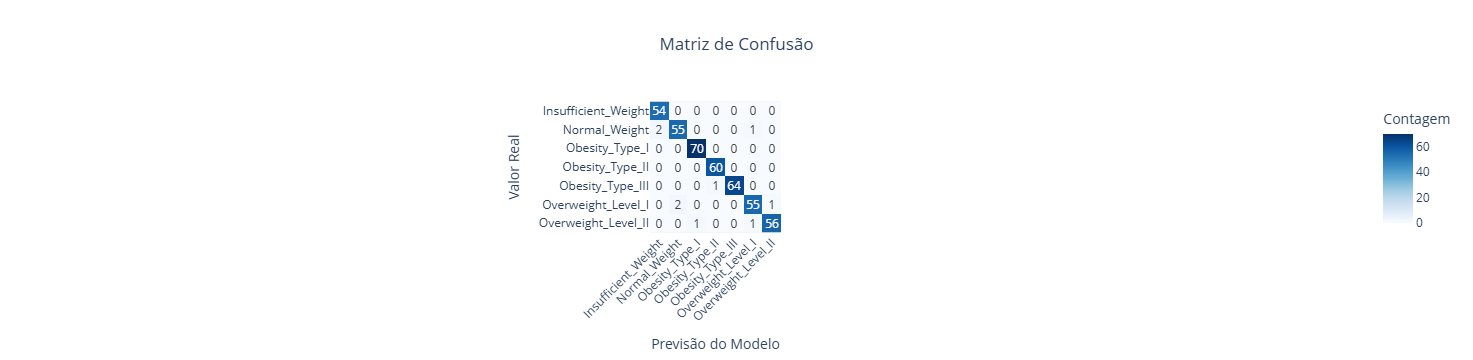

In [15]:
# CÉLULA 10: MATRIZ DE CONFUSÃO VISUAL

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred_decoded, labels=le.classes_)

# Criar um gráfico de mapa de calor para a matriz de confusão
fig = px.imshow(cm,
                labels=dict(x="Previsão do Modelo", y="Valor Real", color="Contagem"),
                x=le.classes_,
                y=le.classes_,
                text_auto=True,
                color_continuous_scale='Blues',
                title="Matriz de Confusão")

fig.update_layout(title_x=0.5, xaxis_tickangle=-45)
fig.show()

In [16]:
# CÉLULA 11: SALVANDO OS ARTEFATOS DO MODELO

# 1. Definir os caminhos para salvar os arquivos na pasta 'models'
caminho_pipeline = '../models/pipeline_obesidade.joblib'
caminho_encoder = '../models/label_encoder.joblib'

# 2. Salvar o pipeline final
joblib.dump(pipeline_final, caminho_pipeline)
print(f"Pipeline salvo com sucesso em: {caminho_pipeline}")

# 3. Salvar o Label Encoder
joblib.dump(le, caminho_encoder)
print(f"Label Encoder salvo com sucesso em: {caminho_encoder}")

Pipeline salvo com sucesso em: ../models/pipeline_obesidade.joblib
Label Encoder salvo com sucesso em: ../models/label_encoder.joblib
